In [1]:
import xcast as xc
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob

In [2]:
# setup the folder where you want to work for this project
# either type in the location, or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()
project_dir = os.getcwd()#"/Users/katie/Desktop/trial_pacisl" 

#make subdirectores to organize your work within the project if they don't already exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(data_dir, 'nc_files'), exist_ok = True)
nc_dir = os.path.join(data_dir, 'nc_files')
os.makedirs(os.path.join(project_dir, 'practical_figures'), exist_ok = True)
figure_dir = os.path.join(project_dir, 'practical_figures')

In [33]:
#Pick Some Forecast Models to Test
gcms = ['NMME']#'GEOSS2S','SPEAR', 'CCSM4', 'CanSIPSIC3', 'CFSv2', 
#Pick Some Observed Rainfall Data to Evaluate Predictions
# options include 'UCSB0p05' or CMORPH
obs_name = 'UCSB0p05'

#Pick the date you want to initialize the model, e.g. your current date
initial_date = (2024, 2, 1)

#predictor extent, zone over which you want to train your model
predictor_extent = {
        'west':  120,
        'east': 250,  
        'north': 10,  
        'south': -30
      }

#where you want to target your final analysis
predictand_extent = {
        'west':  153,
        'east': 183,  
        'north': 3,  
        'south': -20
      }

fiji_coordinates = {
        'west':  177,
        'east': 182,  
        'north': -15,  
        'south': -20}

kiribati_coordinates = {
        'west':  155,
        'east': 178,  
        'north': 2,  
        'south': 0}

solomon_coordinates = {
        'west':  155,
        'east': 167,  
        'north': -13,  
        'south': -6}

region_of_interest = 'kiribati'

#cross validation window - how many years to leave out for testing while training model

In [34]:
#this cell is setup to calculate your target forecast months based on your initialization date
#the forecast months are currently seto to be 1-3, 2-4 and 3-5 months ahead
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

leads = [['1', '3'],['2', '4']]#, ['3','5']]
initial_month = dt.datetime(*initial_date).month
initial_month_name = number_to_month_name_dictionary[initial_month]
target_months = []
target_seas = []
for l in leads:
    target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
    target_mid = number_to_month_name_dictionary[(initial_month + float(l[0])+1)%12]
    target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
    target_seas.append('-'.join([target_low, target_high]))
    target_months.append(target_low[0] + target_mid[0] + target_high[0])
print('Target seasons to forecast')
print(target_seas)

Target seasons to forecast
['Mar-May', 'Apr-Jun']


In [52]:
Y.dims

Frozen({'Y': 800, 'X': 960, 'T': 43})

In [51]:
coordinate_conversion = {
    'latitude': 'Y',
    'lat': 'Y',
    'Y': 'Y',
    'longitude': 'X',
    'lon': 'X',
    'X': 'X',
    'time': 'T',
    'year': 'T',
    'season': 'season',
    'T': 'T'
}

obs_file = '{}*.nc'.format('_'.join([target, obs_name, 'pac-islands']))
Y = xr.open_dataset(glob.glob(os.path.join(nc_dir, obs_file))[0])
og_coords = list(Y.coords)
for o in og_coords:
    Y = Y.rename({o:coordinate_conversion[o]})
Y

<xarray.Dataset>
Dimensions:  (Y: 800, X: 960, T: 43)
Coordinates:
  * Y        (Y) float32 9.975 9.925 9.875 9.825 ... -29.82 -29.88 -29.92 -29.98
  * X        (X) float32 140.0 140.1 140.1 140.2 ... 187.8 187.9 187.9 188.0
  * T        (T) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022 2023
    season   object ...
Data variables:
    precip   (T, Y, X) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [37]:
obs_leads = []
for t, target in enumerate(target_months):
    #obs_download_file = '{}*.nc'.format('_'.join([target_months[t], obs_name]))
    if obs_name == 'CMORPH':
        obs_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + str(t + 1), obs_name]))
    elif 'UCSB' in obs_name:
        obs_file = '{}*.nc'.format('_'.join([target, obs_name, 'pac-islands']))
    Y = xr.open_dataset(glob.glob(os.path.join(nc_dir, obs_file))[0])
    Y.coordinates()
    Y = getattr(Y, [i for i in Y.data_vars][0])
    if obs_name == 'CMORPH':
      Y = Y.rename({'lat':'Y', 'lon':'X', 'time':'T'}).expand_dims({'M':[0]})  
    Y = Y.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    obs_leads.append(Y)

#check all years are available for all lead times in hindcast period, only keep intersecting years
nyears = []
for obs in obs_leads:
    nyears.append(len(np.unique(obs.S.values)))
if all(i==nyears[0] for i in nyears) == True:
    obs_leads = xr.concat(obs_leads, dim = 'L')
else:
    seas_years = []
    for obs in obs_leads:
        base_obs = obs.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        seas_years.append(np.unique(base_obs.T.dt.year.values))
    intersecting_years = [x for x in seas_years[0] if x in seas_years[1] and x in seas_years[2]]

    updated_obs = []
    for obs in obs_leads:
        obs_check = obs.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        updated_obs.append(obs_check.sel(T=obs_check.T.dt.year.isin(intersecting_years)).swap_dims({'T':'S'}).prec)
    obs_leads = xr.concat(updated_obs, dim = 'L')

ValueError: cannot swap from dimension 'T' because it is not an existing dimension

In [ ]:
t=0
obs_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + str(t + 1), obs_name]))
Y = xr.open_dataset(glob.glob(os.path.join(nc_dir, obs_download_file))[0])
Y.isel(time=50).precip.plot()

In [99]:
# read in hindcast and forecast data
hindcast_data, forecast_data = [], []
for t, target in enumerate(target_months):
    hindcast_data_l, forecast_data_l = [], []
    for gcm in gcms:
        
        # gcm_hindcast_download_file = '{}*.nc'.format('_'.join([target, '_'.join(leads[t]), 'raw_hind', gcm]))
        # gcm_forecast_download_file = '{}*.nc'.format('_'.join([target, '_'.join(leads[t]), 'raw_fcst', gcm]))
        gcm_hindcast_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + leads[t][0], gcm, 'hind']))
        gcm_forecast_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + leads[t][0], gcm, 'fcst']))
        g = xr.open_dataset(glob.glob(os.path.join(nc_dir, gcm_hindcast_download_file))[0]).precip
        f = xr.open_dataset(glob.glob(os.path.join(nc_dir, gcm_forecast_download_file))[0]).precip
        g = g.rename({'lat':'Y', 'lon':'X', 'time':'T'}).expand_dims({'M':[gcm]})
        f = f.rename({'lat':'Y', 'lon':'X', 'time':'T'}).expand_dims({'M':[gcm]})
        hindcast_data_l.append(g)
        forecast_data_l.append(f)
    hindcast_data_l = xr.concat(hindcast_data_l, dim = 'M')
    forecast_data_l = xr.concat(forecast_data_l, dim = 'M')
    hindcast_data_l = hindcast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    forecast_data_l = forecast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    hindcast_data.append(hindcast_data_l)
    forecast_data.append(forecast_data_l)

#create one dataset across all lead times of interest
forecast_data = xr.concat(forecast_data, dim = 'L')
#check all hindcast years are available for all lead times and only keep dataset with intersecting years
nyears = []
for hcsts in hindcast_data:
    nyears.append(len(np.unique(hcsts.S.values)))
if all(i==nyears[0] for i in nyears) == True:
    hindcast_data = xr.concat(hindcast_data, dim = 'L')
else:
    seas_years = []
    for hcst in hindcast_data:
        base_hcsts = hcst.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        seas_years.append(np.unique(base_hcsts.T.dt.year.values))
    intersecting_years = [x for x in seas_years[0] if x in seas_years[1] and x in seas_years[2]]

    updated_hcsts = []
    for hcst in hindcast_data:
        hcst_check = hcst.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        updated_hcsts.append(hcst_check.sel(Ti=hcst_check.Ti.dt.year.isin(intersecting_years)).swap_dims({'T':'S'}).prec)
    hindcast_data = xr.concat(updated_hcsts, dim = 'L')

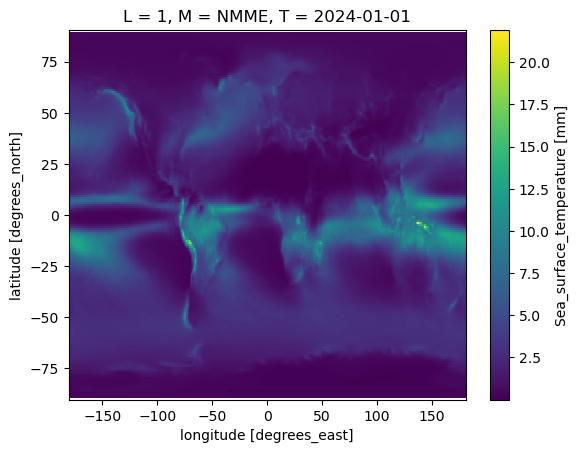

In [100]:
hindcast_data.isel(S=0,L=0).plot()

In [77]:
hindcast_comp = []
obs_comp = []
for l in np.unique(hindcast_data.L):
    model = hindcast_data.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')
    obs = obs_leads.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')

    model_years = np.unique(model.T.dt.year.values)
    obs_years = np.unique(obs.T.dt.year.values)
    intersecting_years = [x for x in obs_years if x in model_years]
    hindcast_comp.append(model.sel(T=model.T.dt.year.isin(intersecting_years)).prec.swap_dims({'T':'S'}))
    obs_comp.append(obs.sel(T=obs.T.dt.year.isin(intersecting_years)).prec.swap_dims({'T':'S'}))
hindcast_comp = xr.concat(hindcast_comp, dim = 'L')
obs_comp = xr.concat(obs_comp, dim = 'L')

In [78]:
#adjust longitude from 0-360 to -180 to 180
#inputs: xarray dataset, name of longitude variable (string)
#outputs: xarray data with longitude 0-360 grid
def adjust_longitude_to_360(ds, name_of_longitude_var):
    ds_to_change = ds.copy()
    ds_to_change.coords[name_of_longitude_var] = (ds_to_change.coords[name_of_longitude_var] + 360) % 360
    ds_to_change = ds_to_change.sortby(ds_to_change[name_of_longitude_var])
    return ds_to_change

In [79]:
obs_comp

<xarray.DataArray 'prec' (L: 3, M: 1, S: 75, Y: 401, X: 1441)>
array([[[[[2.03490567, 1.97941923, 1.96434927, ..., 2.11404896,
           2.08622313, 2.03490567],
          [2.21618199, 2.1475625 , 2.11008286, ..., 2.3266387 ,
           2.28385234, 2.21618199],
          [2.284477  , 2.22595668, 2.17995167, ..., 2.45317125,
           2.37495732, 2.284477  ],
          ...,
          [3.15596581, 3.16313291, 3.06863832, ..., 2.64831138,
           2.91891956, 3.15596581],
          [3.02377081, 3.07455707, 3.0005312 , ..., 2.68459582,
           2.86050224, 3.02377081],
          [2.5761292 , 2.67229795, 2.68295479, ..., 2.40703678,
           2.47270679, 2.5761292 ]],

         [[0.74214762, 0.74478006, 0.78964698, ..., 0.78126901,
           0.75877231, 0.74214762],
          [0.76700795, 0.77873671, 0.82149768, ..., 0.79625696,
           0.77540767, 0.76700795],
          [0.85652941, 0.87100345, 0.88757575, ..., 0.87338185,
           0.85652488, 0.85652941],
...
          [2.7855885 , 2.69210601, 2.64628625, ..., 2.70850134,
           2.80086446, 2.7855885 ],
          [2.71393609, 2.6772182 , 2.64354563, ..., 2.60257554,
           2.68590951, 2.71393609],
          [2.63870478, 2.66488361, 2.65307331, ..., 2.4860909 ,
           2.56608987, 2.63870478]],

         [[1.89121842, 1.81597197, 1.77378094, ..., 1.97808897,
           1.94288743, 1.89121842],
          [1.72923088, 1.6837014 , 1.69860685, ..., 1.81400943,
           1.79032278, 1.72923088],
          [1.67214072, 1.64183152, 1.63729   , ..., 1.76227891,
           1.73867691, 1.67214072],
          ...,
          [2.57211781, 2.55980778, 2.57139754, ..., 2.49465466,
           2.55391645, 2.57211781],
          [2.57292771, 2.59657955, 2.64003825, ..., 2.47041821,
           2.54042196, 2.57292771],
          [2.61007857, 2.65762901, 2.74423242, ..., 2.502913  ,
           2.57495165, 2.61007857]]]]])
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) int64 0
  * Y        (Y) float32 -50.0 -49.75 -49.5 -49.25 ... 49.25 49.5 49.75 50.0
  * X        (X) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8 180.0
    T        (S) datetime64[ns] 2024-01-12 2025-01-12 ... 2097-01-12 2098-01-12
Dimensions without coordinates: S
Attributes:
    units:          mm
    standard_name:  Precip

In [80]:
obs_360 = adjust_longitude_to_360(obs_comp, 'X').sortby('Y', ascending = True).sortby('X', ascending = True)
obs_comp = obs_360.sel(X= slice(predictand_extent['west'], predictand_extent['east']),
                        Y = slice(predictand_extent['south'], predictand_extent['north']))

In [81]:
hindcast_360 = adjust_longitude_to_360(hindcast_comp, 'X').sortby('Y', ascending = True).sortby('X', ascending = True)
hindcast_comp = hindcast_360.sel(X= slice(predictor_extent['west'], predictor_extent['east']),
                        Y = slice(predictor_extent['south'], predictor_extent['north']))

In [84]:
hindcast_comp

<xarray.DataArray 'prec' (L: 3, M: 1, S: 75, Y: 41, X: 132)>
array([[[[[         nan,          nan,          nan, ...,
           297.63601685, 297.59317017, 297.56604004],
          [         nan,          nan,          nan, ...,
           298.02383423, 297.98077393, 297.94137573],
          [         nan,          nan,          nan, ...,
           298.32821655, 298.28097534, 298.22299194],
          ...,
          [301.49307251, 301.6388855 , 300.80224609, ...,
           299.62557983, 299.59893799, 299.55847168],
          [301.24273682, 301.25234985, 300.47766113, ...,
           299.58413696, 299.55499268, 299.52676392],
          [300.9928894 , 301.03448486,          nan, ...,
           299.5725708 , 299.56384277, 299.55328369]],

         [[         nan,          nan,          nan, ...,
           296.27328491, 296.23791504, 296.18606567],
          [         nan,          nan,          nan, ...,
           296.70535278, 296.65048218, 296.57278442],
          [         nan,          nan,          nan, ...,
           297.07550049, 296.99890137, 296.89874268],
...
          [303.24002075, 303.23022461, 302.15869141, ...,
           301.49209595, 301.49328613, 301.48605347],
          [303.04000854, 302.99850464, 302.11886597, ...,
           301.67089844, 301.67453003, 301.68130493],
          [302.96469116, 302.84646606,          nan, ...,
           301.80865479, 301.83270264, 301.86459351]],

         [[         nan,          nan,          nan, ...,
           294.20404053, 294.15203857, 294.13317871],
          [         nan,          nan,          nan, ...,
           294.67230225, 294.6111145 , 294.58599854],
          [         nan,          nan,          nan, ...,
           295.07070923, 294.99047852, 294.94564819],
          ...,
          [303.32034302, 303.27697754, 302.07507324, ...,
           301.425354  , 301.42462158, 301.42028809],
          [303.20626831, 303.15975952, 302.31600952, ...,
           301.61248779, 301.61206055, 301.61917114],
          [303.20437622, 303.07293701,          nan, ...,
           301.8013916 , 301.81335449, 301.83596802]]]]])
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) object 'NMME'
  * Y        (Y) float32 -30.0 -29.0 -28.0 -27.0 -26.0 ... 6.0 7.0 8.0 9.0 10.0
  * X        (X) float32 120.0 121.0 122.0 123.0 ... 247.0 248.0 249.0 250.0
    T        (S) datetime64[ns] 2024-01-01 2025-01-01 ... 2097-01-01 2098-01-01
Dimensions without coordinates: S
Attributes:
    units:          mm
    standard_name:  Sea_surface_temperature

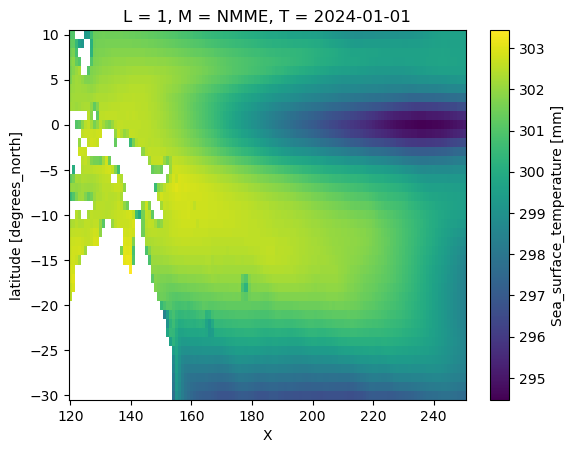

In [83]:
hindcast_comp.isel(S=0,L=0).plot()

In [69]:
## make sure to update obs_leads to obs_comp

In [85]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, obs_test_L = [],[],[],[],[]

for l in np.unique(hindcast_comp.L):
    model = hindcast_comp.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')
    obs = obs_comp.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')
    fmodel = forecast_data.sel(L=l).swap_dims({'S':'T'})

    model_years = np.unique(model.T.dt.year.values)
    obs_years = np.unique(obs.T.dt.year.values)
    intersecting_years = [x for x in obs_years if x in model_years]
    model = model.sel(T=model.T.dt.year.isin(intersecting_years)).prec
    obs = obs.sel(T=obs.T.dt.year.isin(intersecting_years)).prec
    #run CCA
    hindcasts_det, hindcasts_prob, obs_test = [], [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=15):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(10,
                                      10,
                                     3))
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
        obs_test.append(ytest)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    
    fprobs =  reg.predict_proba(fmodel)
    
    cca_fcsts_prob.append(fprobs.swap_dims({'T':'S'}))
    cca_hcasts_det.append(hindcasts_det.swap_dims({'T':'S'}))
    cca_hcasts_prob.append(hindcasts_prob.swap_dims({'T':'S'}))
    obs_test_L.append(obs_test)
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
print('cca processing time is ' + str(time.time() - start_time))

window 1


InvalidIndexError: Reindexing only valid with uniquely valued Index objects